In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load OSX 2D keypoints

In [2]:
# Load 2D joint outputs from OSX (num_videos x num_frames x num_joints (=127) x num_coordinates(=2))
# Each video is flattened to a single row of entry

pickle_path = '/home/ubuntu/OSX/output/STS_test6/log/'
joint_2d_out = np.array(pickle.load(open(os.path.join(pickle_path, "joint_2d_out.p"), "rb")))
video_list_2d = pickle.load(open(os.path.join(pickle_path, "video_list_2d.p"), "rb"))

num_samples = joint_2d_out.shape[0]
joint_2d_out = joint_2d_out.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
joint_2d_out_pd = pd.DataFrame(joint_2d_out)
joint_2d_out_pd.insert(0, 'subjectid', video_list_2d)

print(joint_2d_out_pd.shape)
joint_2d_out_pd


(349, 226051)


,subjectid,0,1,2,3,4,5,6,7,8,...,226040,226041,226042,226043,226044,226045,226046,226047,226048,226049
0,5k0NQN5p,7.221850,7.885120,7.107759,8.85057,6.702912,8.65661,4.165856,10.16777,3.336421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5ghmRK1h,4.743039,7.377490,5.248542,8.02348,4.719424,8.41173,8.424732,8.72170,6.981372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyqYkUq8,7.221160,8.064100,7.449670,8.96562,6.729481,8.81459,5.656837,10.71710,3.994794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ovgMFqBi,4.804083,7.801736,5.357444,8.40570,4.856543,8.91970,8.855057,9.00550,7.441838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZK2JlJsq,5.011049,6.799740,5.258475,7.52679,4.491357,7.84622,8.503082,8.95842,6.407476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,CAMRbQ1K,6.431501,7.475290,6.792657,8.31080,5.868254,8.31983,5.779558,10.30755,4.222759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,uBFpj4lx,5.009116,7.670100,5.609162,8.44622,4.754147,8.66131,8.653259,9.11990,5.648183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,CWf3eyvo,5.290886,7.845200,5.875684,8.51200,5.153247,8.81405,8.746249,9.19360,6.395844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,bqTsXpKl,6.950295,7.681124,7.249909,8.56967,6.356339,8.46919,6.311265,10.42697,3.660695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [3]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [4]:
# join the dataframes by subjectId 
df_join = joint_2d_out_pd.set_index('subjectid').join(df_survey.set_index('subjectid'), how='inner')
print(df_join.shape)
df_join

(349, 226051)


,0,1,2,3,4,5,6,7,8,9,...,226041,226042,226043,226044,226045,226046,226047,226048,226049,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
5k0NQN5p,7.221850,7.885120,7.107759,8.85057,6.702912,8.65661,4.165856,10.16777,3.336421,9.00195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5ghmRK1h,4.743039,7.377490,5.248542,8.02348,4.719424,8.41173,8.424732,8.72170,6.981372,9.69726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
nyqYkUq8,7.221160,8.064100,7.449670,8.96562,6.729481,8.81459,5.656837,10.71710,3.994794,9.97395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ovgMFqBi,4.804083,7.801736,5.357444,8.40570,4.856543,8.91970,8.855057,9.00550,7.441838,10.33909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ZK2JlJsq,5.011049,6.799740,5.258475,7.52679,4.491357,7.84622,8.503082,8.95842,6.407476,9.65356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMRbQ1K,6.431501,7.475290,6.792657,8.31080,5.868254,8.31983,5.779558,10.30755,4.222759,10.35056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
uBFpj4lx,5.009116,7.670100,5.609162,8.44622,4.754147,8.66131,8.653259,9.11990,5.648183,9.79324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
CWf3eyvo,5.290886,7.845200,5.875684,8.51200,5.153247,8.81405,8.746249,9.19360,6.395844,10.34420,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Data validation 

In [5]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [6]:
# 349 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [7]:
# Check for number of OA positive and number of samples in the dataset
print(df_join['OA_check'].count())  # 349
print(df_join['OA_check'].sum())    # 21
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data['OA_check'].count())  # 279
print(train_data['OA_check'].sum())    # 17

# Validation set - This implies that if the model always predicts 0, it would have 94% val accuracy
print(val_data['OA_check'].count())  # 35
print(val_data['OA_check'].sum())    # 2

# Test set - This implies that if the model always predicts 0, it would have 94% test accuracy
print(test_data['OA_check'].count())  # 35
print(test_data['OA_check'].sum())    # 2

349
21
279
17
35
2
35
2


#### Normalization
Skipped normalization as the data is already within a narrow range. Also, later columns often have very few data points (e.g. 1) making normalization difficult.

#### Create dataloaders

In [8]:
# without normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

In [9]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 226050]) torch.Size([64])
tensor([[6.8903, 7.4860, 7.1059,  ..., 0.0000, 0.0000, 0.0000],
        [4.8123, 7.3907, 5.4076,  ..., 0.0000, 0.0000, 0.0000],
        [5.7035, 7.3980, 6.1567,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.9259, 7.6860, 5.3623,  ..., 0.0000, 0.0000, 0.0000],
        [5.3757, 7.4970, 5.9308,  ..., 0.0000, 0.0000, 0.0000],
        [5.1045, 7.4253, 5.6635,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


#### Create a manually curated data set
Skipped

#### Create dataloaders with upsampling 

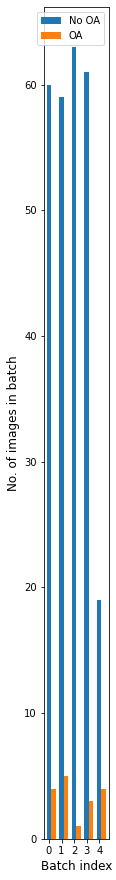

Avg Proportion of No OA per batch: 5.239999999999999
Avg Proportion of OA per batch: 0.34
Num. unique images seen: 279/279


In [10]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

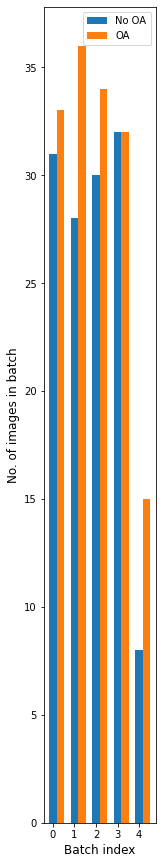

Avg Proportion of No OA per batch: 2.5800000000000005
Avg Proportion of OA per batch: 3.0
Num. unique images seen: 119/279


In [11]:
train = CustomDataset(dataframe=train_data, transform=None)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with unnormalized inputs, no oversampling

In [12]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 226050
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

RuntimeError: CUDA out of memory. Tried to allocate 1.69 GiB (GPU 0; 14.76 GiB total capacity; 1.74 GiB already allocated; 930.75 MiB free; 1.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, with oversampling

In [ ]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 226050
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, with weighted loss

In [ ]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=16, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=16, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=16)

input_size = 226050
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 11.2503, train_acc = 72.4014, val_acc = 85.7143, train_pos = 24.3728, val_pos = 8.5714
Epoch 1, loss = 0.2070, train_acc = 49.1039, val_acc = 91.4286, train_pos = 51.9713, val_pos = 2.8571
Epoch 2, loss = 0.3598, train_acc = 80.6452, val_acc = 94.2857, train_pos = 18.2796, val_pos = 0.0000
Epoch 3, loss = 0.3487, train_acc = 69.1756, val_acc = 94.2857, train_pos = 30.4659, val_pos = 0.0000
Epoch 4, loss = 2.1320, train_acc = 66.3082, val_acc = 91.4286, train_pos = 31.8996, val_pos = 2.8571
Epoch 5, loss = 0.7462, train_acc = 85.6631, val_acc = 91.4286, train_pos = 12.5448, val_pos = 2.8571
Epoch 6, loss = 0.8319, train_acc = 81.3620, val_acc = 91.4286, train_pos = 18.2796, val_pos = 2.8571
Epoch 7, loss = 0.5100, train_acc = 62.7240, val_acc = 91.4286, train_pos = 37.6344, val_pos = 2.8571
Epoch 8, loss = 1.1823, train_acc = 74.9104, val_acc = 28.5714, train_pos = 24.0143, val_pos = 71.4286
Epoch 9, loss = 0.9878, train_acc = 81.0036, val_acc = 42.8571, train_pos = 17.9

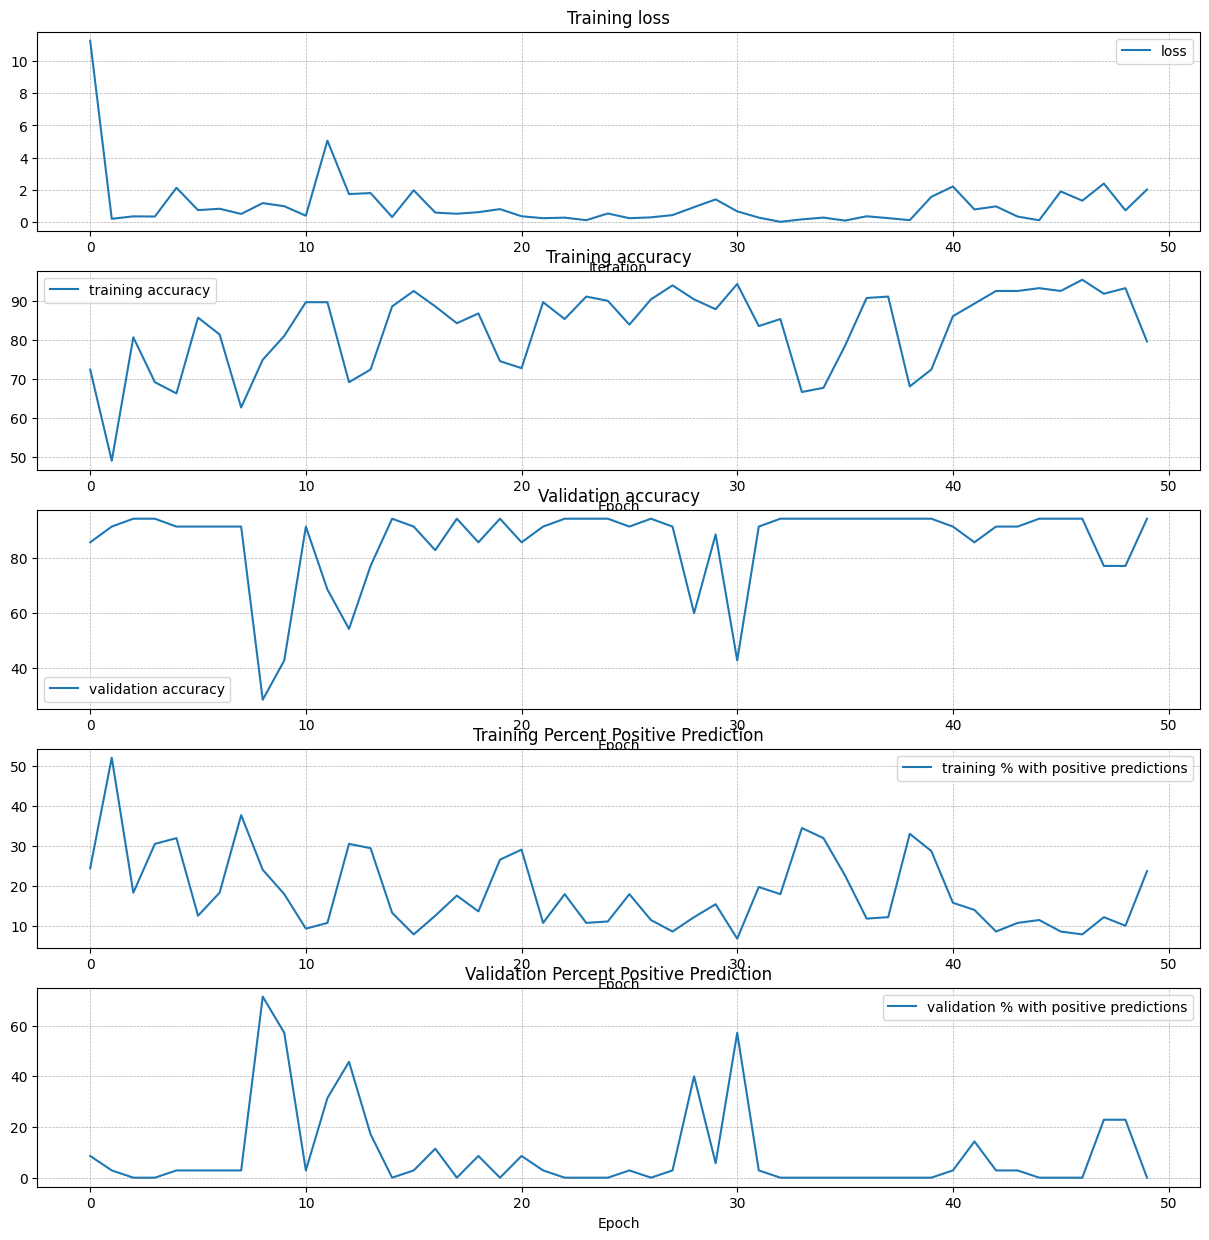

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized (body + hand only) inputs, no oversampling, with weighted loss

In [ ]:
print(train_data.iloc[:3,])
train_data_bh = train_data.iloc[:, [:66, -1]]   # OA_check + the first 65 features which are body + hand features (exclude face)
print(train_data_bh.iloc[:3,])
# TODO: apply similar changes to val and test data

SyntaxError: invalid syntax (2568494464.py, line 2)

In [ ]:
train = CustomDataset(dataframe=train_data_bh, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data_bh, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data_bh, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()